# Cut and Fill Volume Analysis from DTM

This notebook estimates **cut and fill volumes** using a Digital Terrain Model (DTM) and a boundary polygon that defines the work area.

The workflow computes the difference between the existing ground (DTM) and the **target design elevation** to identify where material must be **cut (removed)** or **filled (added)**.

---

## Core Formula and Concept

For each pixel in the DTM:

\[
D = E_{target} - E₍DTM₎
\]

Where:
- **D** = Elevation difference (m)
  - Positive → Fill (add material)
  - Negative → Cut (remove material)
- **E₍DTM₎** = Existing ground elevation
- **E₍target₎** = Target or design elevation

Each pixel represents a known ground area (based on raster resolution).  
Hence, total cut/fill volume is computed as:

\[
V = \sum (D \times * A₍pixel₎)
\]

Where:
- **V** = Total cut/fill volume (m³)
- **A₍pixel₎** = Pixel area = (resolution²)

This approach provides a pixel-by-pixel estimate of earthwork requirements.

---


### Step 1: Import Libraries

In [1]:
import rasterio
from rasterio.mask import mask
from rasterio.features import rasterize
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Step 2: Input Data
We load:
- **DTM raster** (existing surface)
- **Polygon shapefile** (boundary of project area)

In [2]:
dem_path = r"raw_data/Assignment_1_DTM.tif"
polygon_path = r"raw_data/Base_boundary.shp"

### Step 3: Output Paths
Define file names for saving results.

In [3]:
out_final = "final_elevation.tif"
out_diff  = "diff_target_minus_dem.tif"
out_mask  = "polygon_mask.tif"
out_csv   = "cut_fill_volumes.csv"
plot_png  = "cut_fill_map.png"

### Step 4: Define Target Elevations
the two design levels that were provided to us:
- Inside polygon → 331.26 m  
- Outside polygon → 329.50 m

In [4]:
cut_level = 331.26
fill_level = 329.50

### Step 5: Clipping DTM to Polygon Extent for reduces compute time and avoid calculating for irrelevant area.

In [5]:
gdf = gpd.read_file(polygon_path)

with rasterio.open(dem_path) as src:
    dem_clip_arr, transform = mask(src, gdf.geometry, crop=True)
    dem = dem_clip_arr[0].astype(float)
    profile = src.profile.copy()
    profile.update({
        "height": dem.shape[0],
        "width": dem.shape[1],
        "transform": transform
    })
    nodata_val = src.nodata

### Step 6: Replacing of nodata values with NaN for safe calculations.

In [6]:
if nodata_val is not None:
    dem[dem == nodata_val] = np.nan
else:
    dem[dem == 0] = np.nan

### Step 7: just to verify if the clipped raster was generated correctly.

In [7]:
print("Clipped DEM shape:", dem.shape)
print("Total pixels:", dem.size,
      "Valid pixels:", np.sum(np.isfinite(dem)),
      "NaN pixels:", np.sum(np.isnan(dem)))
print("DEM valid min/max:", np.nanmin(dem), np.nanmax(dem))

Clipped DEM shape: (14672, 11304)
Total pixels: 165852288 Valid pixels: 114767216 NaN pixels: 51085072
DEM valid min/max: 322.7312927246094 339.4639892578125


### Step 6: Classify Cut / Fill / Stable

In [8]:
final_surface = dem.copy()

final_surface[dem > cut_level] = cut_level
final_surface[dem < fill_level] = fill_level

### Step 7: Difference Map (Target - DEM)

In [9]:
diff = final_surface - dem 

### Step 8: Computing Volume Calculation
Calculate where and how much each pixel differs from the target.

In [10]:
cell_area = abs(transform[0] * transform[4])  # pixel area in m²
valid_mask = np.isfinite(diff)

fill_pixels = diff > 0
cut_pixels  = diff < 0

fill_volume_total = np.sum(diff[fill_pixels]) * cell_area
cut_volume_total  = np.sum(-diff[cut_pixels]) * cell_area

print(f"Fill total (m³): {fill_volume_total:,.2f}")
print(f"Cut total  (m³): {cut_volume_total:,.2f}")
print(f"Net (m³): {fill_volume_total - cut_volume_total:,.2f}")

Fill total (m³): 148,896.54
Cut total  (m³): 1,037,303.62
Net (m³): -888,407.08


### Step 9: Save Outputs

In [11]:
out_profile = profile.copy()
out_profile.update(dtype=rasterio.float32, count=1, nodata=np.float32(0))

final_write = np.where(np.isfinite(final_surface), final_surface, out_profile["nodata"]).astype(np.float32)
with rasterio.open(out_final, "w", **out_profile) as dst:
    dst.write(final_write, 1)

diff_write = np.where(np.isfinite(diff), diff, out_profile["nodata"]).astype(np.float32)
with rasterio.open(out_diff, "w", **out_profile) as dst:
    dst.write(diff_write, 1)

df = pd.DataFrame({
    "fill_m3": [fill_volume_total],
    "cut_m3": [cut_volume_total],
    "net_m3": [fill_volume_total - cut_volume_total]
})
df.to_csv(out_csv, index=False)
print("Saved:", out_final, out_diff, out_csv)

Saved: final_elevation.tif diff_target_minus_dem.tif cut_fill_volumes.csv


### Step 11: Visualization

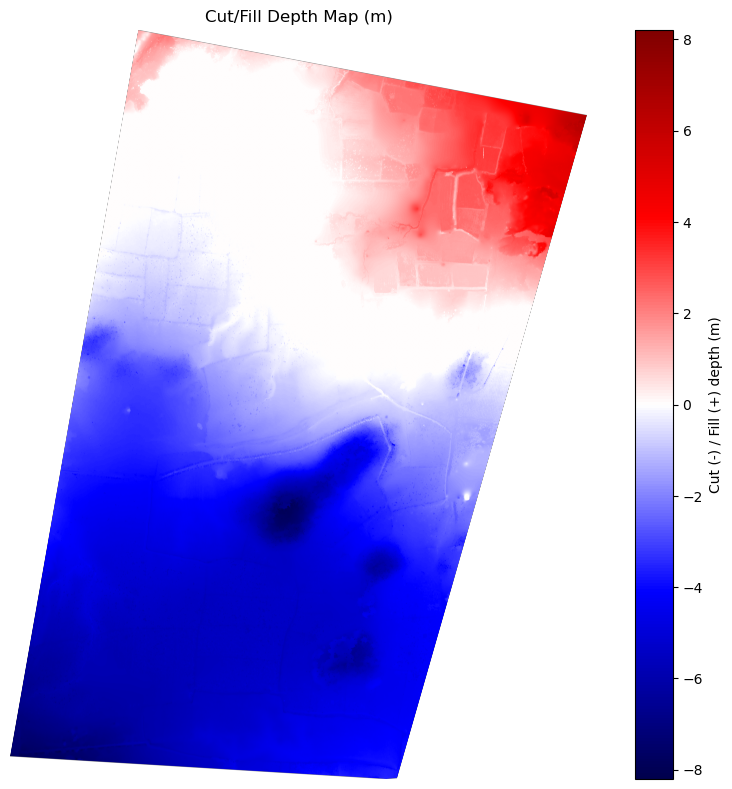

In [12]:
fig, ax = plt.subplots(figsize=(10, 8))
cmap = plt.cm.seismic
norm = plt.Normalize(vmin=-np.nanmax(abs(diff)), vmax=np.nanmax(abs(diff)))
im = ax.imshow(diff, cmap=cmap, norm=norm)
fig.colorbar(im, ax=ax, label="Cut (-) / Fill (+) depth (m)")
ax.set_title("Cut/Fill Depth Map (m)")
ax.axis("off")
plt.tight_layout()
plt.savefig(plot_png, dpi=200)
plt.show()

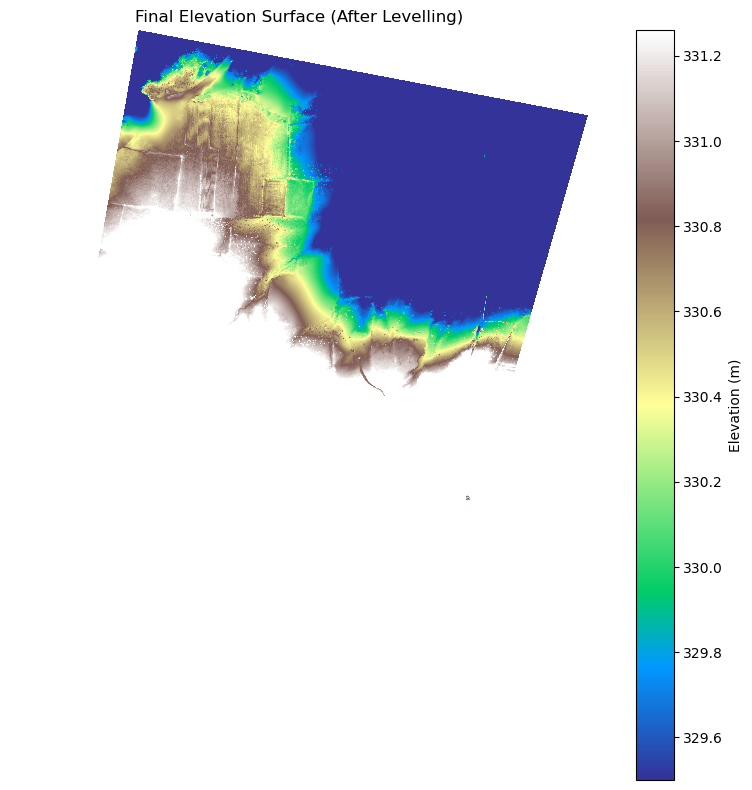

In [13]:
fig, ax = plt.subplots(figsize=(10, 8))
c = ax.imshow(final_surface, cmap="terrain", interpolation="nearest")
fig.colorbar(c, ax=ax, label="Elevation (m)")
ax.set_title("Final Elevation Surface (After Levelling)")
ax.axis("off")
plt.tight_layout()
plt.show()

##  Step 12: Interpretation of Results

The `cut_fill_volumes.csv` file summarizes the total cut, fill, and net balance.

| Region | Fill (m³) | Cut (m³) | Net (m³) |
|---------|-----------|----------|-----------|
| Inside Polygon | Material added (fill) | Material removed (cut) | Net balance |
| Outside Polygon | Reference area (usually zero) |  |  |
| Total | Combined across study area |  |  |

### How to Read:
- **Positive Net Volume →** More fill required (material to import).  
- **Negative Net Volume →** More cut required (material to remove).  
- **Zero Net Volume →** Balanced (ideal scenario).  

Blue zones in the depth map mark **cuts**, red zones mark **fills**, and the magnitude indicates the vertical difference (in meters).

---

### Conclusion
This method provides a transparent and reproducible workflow for **terrain modification planning**.  
By combining raster-based elevation data and polygon boundaries, it precisely quantifies material movement requirements for construction, road design, or land grading projects.
